# 2022-02-07 • Big-N-to-1 simulation

## Setup

In [1]:
# Pkg.resolve()

In [2]:
include("nb_init.jl")

[ Info: using Revise
[ Info: import Distributions
[ Info: import MyToolbox
[ Info: Precompiling MyToolbox [54cd1024-cafd-4d62-948d-ced4874502bf]
[ Info: using VoltageToMap
[ Info: Precompiling VoltageToMap [b3b8fdc5-3c26-4000-a0c8-f17415fdf48e]


In [3]:
using Parameters, ComponentArrays
@alias CVec = ComponentVector;

## Parameters

### Simulation duration

In [4]:
sim_duration = 1.2 * seconds;

### Input spike trains

In [5]:
N_unconn = 100
N_exc    = 800
# N_exc    = 5200
N_inh    = N_exc ÷ 4

200

In [6]:
N_conn = N_inh + N_exc

1000

In [7]:
N = N_conn + N_unconn

1100

In [8]:
input_spike_rate = LogNormal_with_mean(4Hz, √0.6)  # See the previous notebook

LogNormal{Float64}(μ=1.0862943611198905, σ=0.7745966692414834)

### Synapses

Reversal potential at excitatory and inhibitory synapses,
as in the report [`2021-11-11__synaptic_conductance_ratio.pdf`](https://github.com/tfiers/phd-thesis/blob/main/reports/2021-11-11__synaptic_conductance_ratio.pdf):

In [9]:
E_exc =   0 * mV
E_inh = -65 * mV;

Synaptic conductances `g` at `t = 0`

In [10]:
g_t0 = 0 * nS;

Exponential decay time constant of synaptic conductance, $τ_{s}$ (`s` for "synaptic")

In [11]:
τ_s = 7 * ms;

Increase in synaptic conductance on a presynaptic spike

In [12]:
Δg_exc = 0.1 * nS
Δg_inh = 0.4 * nS;

### Izhikevich neuron

Initial membrane potential `v` and adaptation variable `u` values

In [13]:
v_t0  = -80 * mV
u_t0  =   0 * pA;

Izhikevich's neuron model parameters for a cortical regular spiking neuron:

In [14]:
cortical_RS = CVec(
    C      = 100 * pF,
    k      = 0.7 * (nS/mV),  # steepness of dv/dt's parabola
    vr     = -60 * mV,
    vt     = -40 * mV,
    a      = 0.03 / ms,      # 1 / time constant of `u`
    b      = -2 * nS,        # how strongly `v` deviations from `vr` increase `u`.
    v_peak =  35 * mV,
    c      = -50 * mV,       # reset voltage.
    d      = 100 * pA,       # `u` increase on spike. Free parameter.
);

### Numerics

Whether to use a fixed (`false`) or [adaptive](https://www.wikiwand.com/en/Adaptive_step_size) timestep (`true`).

In [15]:
adaptive = true;

Timestep. If `adaptive`, size of first time step.

In [16]:
dt    = 0.1 * ms;

Minimum and maximum step sizes

In [17]:
dtmax = 0.5  * ms  # solution unstable if not set
dtmin = 0.01 * ms;  # don't spend too much time finding thr crossing or spike arrival

Error tolerances used for determining step size, if `adaptive`.

The solver guarantees that the (estimated) difference between
the numerical solution and the true solution at any time step
is not larger than `abstol + reltol * |y|`
(where `y` ≈ the numerical solution at that time step).

In [18]:
abstol_v = 0.1 * mV
abstol_u = 0.1 * pA
abstol_g = 0.01 * nS;

In [19]:
reltol = 1e-3;  # e.g. if true sol is -80 mV, then max error of 0.08 mV
reltol = 1;     # only use abstol

From the manual: "These tolerances are local tolerances and thus are not global guarantees. However, a good rule of thumb is that the total solution accuracy is 1-2 digits less than the relative tolerances." [[1]](https://diffeq.sciml.ai/stable/basics/faq/#What-does-tolerance-mean-and-how-much-error-should-I-expect)

In [20]:
tol_correction = 0.1;

In [21]:
(abstol_v, abstol_u, abstol_g) .* tol_correction

(1.0e-5, 1.0000000000000002e-14, 1.0000000000000002e-12)

For comparison, the default tolerances for ODEs in DifferentialEquations.jl are
- `reltol = 1e-2`
- `abstol = 1e-6`.

## IDs

Neuron, synapse & simulated variable IDs.

IDs and connections are simple here for the N-to-1 case: only input 'neurons' get an ID, and there is only one synapse for every (connected) neuron.

A utility function. See below for its usage.

In [22]:
"""
    idvec(A = 4, B = 2, …)

Build a `ComponentVector` (CVec) with the given group names and
as many elements per group as specified. Each element gets a
unique ID within the CVec, which is also its index in the CVec.
I.e. the above call yields `CVec(A = [1,2,3,4], B = [5,6])`.
"""
function idvec(; kw...)
    cvec = CVec(; (name => _expand(val) for (name, val) in kw)...)
    cvec .= 1:length(cvec)
    return cvec
end;

temp = -1  # value does not matter; they get overwritten by UnitRange
_expand(val::Nothing) = temp
_expand(val::Integer) = fill(temp, val)
_expand(val::CVec)    = val              # allow nested idvecs
;

In [23]:
input_neurons = idvec(conn = idvec(exc = N_exc, inh = N_inh), unconn = N_unconn)

ComponentVector{Int64}(conn = (exc = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  791, 792, 793, 794, 795, 796, 797, 798, 799, 800], inh = [801, 802, 803, 804, 805, 806, 807, 808, 809, 810  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]), unconn = [1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010  …  1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100])

In [24]:
synapses = idvec(exc = N_exc, inh = N_inh)

ComponentVector{Int64}(exc = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  791, 792, 793, 794, 795, 796, 797, 798, 799, 800], inh = [801, 802, 803, 804, 805, 806, 807, 808, 809, 810  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000])

In [25]:
simulated_vars = idvec(v = nothing, u = nothing, g = synapses)

ComponentVector{Int64}(v = 1, u = 2, g = (exc = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12  …  793, 794, 795, 796, 797, 798, 799, 800, 801, 802], inh = [803, 804, 805, 806, 807, 808, 809, 810, 811, 812  …  993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002]))

Example usage of these objects:

Pick some global input neuron ID

In [26]:
n = N_exc + 2

802

We can index globally, or locally: we want the second connected inhibitory neuron

In [27]:
input_neurons[n], input_neurons.conn.inh[2]

(802, 802)

Some introspection, useful for printing & plotting:

In [28]:
labels(input_neurons)[n]

"conn.inh[2]"

## Connections

In [29]:
postsynapses = Dict{Int, Vector{Int}}()  # input_neuron_ID => [synapse_IDs...]

for (n, s) in zip(input_neurons.conn, synapses)
    postsynapses[n] = [s]
end
for n in input_neurons.unconn
    postsynapses[n] = []
end

## Broadcast parameters

A bunch of synaptic parameters are given as scalars, but pertain to multiple synapses at once.
Here we broadcast these scalars to vectors

In [30]:
Δg = similar(synapses, Float64)
Δg.exc .= Δg_exc
Δg.inh .= Δg_inh;

In [31]:
E = similar(synapses, Float64)
E.exc .= E_exc
E.inh .= E_inh;

Initial conditions

In [32]:
vars_t0 = similar(simulated_vars, Float64)
vars_t0.v = v_t0
vars_t0.u = u_t0
vars_t0.g .= g_t0;

Maximum error

In [33]:
abstol = similar(simulated_vars, Float64)
abstol.v = abstol_v
abstol.u = abstol_u
abstol.g .= abstol_g
abstol = abstol .* tol_correction;

## ISI distributions

Generate firing rates $λ$ by sampling from the input spike rate distribution.

In [58]:
λ = similar(input_neurons, Float64)
λ .= rand(input_spike_rate, length(λ));
# showsome(λ)

`Distributions.jl` uses an alternative `Exp` parametrization, namely scale $β$ = 1 / rate.

In [35]:
β = 1 ./ λ;

In [36]:
ISI_distributions = similar(input_neurons, Exponential{Float64})
ISI_distributions .= Exponential.(β);

## Initialize spiking

Generate the first spike time for every input neuron by sampling once from its ISI distribution.

In [37]:
first_spike_times = rand.(ISI_distributions);

Sort these initial spike times by building a priority queue.

In [38]:
upcoming_input_spikes = PriorityQueue{Int, Float64}()

for (neuron, first_spike_time) in enumerate(first_spike_times)
    enqueue!(upcoming_input_spikes, neuron => first_spike_time)
end

## Parameter object

Encapsulate all 'parameters' used in the differential equation function
and the event callback functions in one `NamedTuple`,
which is passed through to these functions by DiffEq.jl.

This is so that we don't need to read these variables
from the global scope (closure), which slows type inference i.e. compilation time.

'parameters' in quotes, cause some values are mutated.

In [39]:
params = (;
    E, Δg, τ_s,
    izh = cortical_RS,
    postsynapses,
    ISI_distributions,
    upcoming_input_spikes,
);

## Differential equations

The derivative functions that define the differential equations.  
Note that discontinuities are defined in the next section.

In [40]:
function f(D, vars, params, _)
    @unpack v, u, g = vars
    @unpack izh, E, τ_s = params
    @unpack C, k, vr, vt, a, b = izh
    I_s = 0.0
    for (gi, Ei) in zip(g, E)
        I_s += gi * (v - Ei)
    end
    D.v = (k * (v - vr) * (v - vt) - u - I_s) / C
    D.u = a * (b * (v - vr) - u)
    D.g .= .-g ./ τ_s
    return nothing
end;

Applied performance optimizations:
- Don't use `I_s = sum(g .* (v .- E))`, which allocates a new array. Rather, we use an accumulating loop.
- `D.g .= …`: elementwise assignment; instead of overwriting `D.g` with a new array that needs to be allocated.
- Parameters via function argument, and not closure of global variables: to speed up type inference (apparently).

About the sign of the synaptic current `I_s`:
membrane current is by convention positive
if positive charges are flowing _out_ of the cell.

For *e.g.* `v = -80 mV` and `Ei = 0 mV` (*i.e.* an excitatory synapse),
we get negative `I_si` (namely `gi * -80 mV`), *i.e.* positive charges flowing in ✔.

## Events

In [41]:
"""
An `Event` encapsulates two functions that determine when and
how to introduce discontinuities in the differential equations:

- `distance` returns some distance to the next event.
   An event occurs when this distance hits zero.
- `on_event!` is called at each event and may modify
   the simulated variables and the parameter object.

Both functions take the parameters `(vars, params, t)`: the simulated
variables, the parameter object, and the current simulation time.
"""
struct Event
    distance
    on_event!
end;

Input spike generation (== arrival, because no transmission delay):

In [43]:
function time_to_next_input_spike(vars, params, t)
    _, next_input_spike_time = peek(params.upcoming_input_spikes)
        # `peek(pq)` simply returns `pq.xs[1]`; i.e. it's fast.
    return t - next_input_spike_time
end

function on_input_spike!(vars, params, t)
    # Process the neuron that just fired.
    # Start by removing it from the queue.
    fired_neuron = dequeue!(params.upcoming_input_spikes)
    
    # Generate a new spike time, and add it to the queue.
    new_spike_time = t + rand(params.ISI_distributions[fired_neuron])
    enqueue!(params.upcoming_input_spikes, fired_neuron => new_spike_time)
    
    # Update the downstream synapses
    # (number of these synapses in the N-to-1 case: 0 or 1).
    for synapse in params.postsynapses[fired_neuron]
        vars.g[synapse] += params.Δg[synapse]
    end

end

input_spike = Event(time_to_next_input_spike, on_input_spike!);

Spiking threshold crossing of Izhikevich neuron:

In [44]:
distance_to_spiking_threshold(vars, params, _) = vars.v - params.izh.v_peak

function on_spiking_threshold_crossing!(vars, params, _)
    # The discontinuous LIF/Izhikevich/AdEx update
    vars.v = params.izh.c
    vars.u += params.izh.d
end

spiking_threshold_crossing = Event(distance_to_spiking_threshold, on_spiking_threshold_crossing!);

In [45]:
events = [input_spike, spiking_threshold_crossing];

## diffeq.jl API

Set-up problem and solution in DifferentialEquations.jl's API.

In [46]:
@withfeedback using OrdinaryDiffEq

[ Info: using OrdinaryDiffEq


In [47]:
prob = ODEProblem(f, vars_t0, float(sim_duration), params)
    # Duration must be float, so that `t` variable is float.

ODEProblem with uType ComponentVector{Float64, Vector{Float64}, Tuple{Axis{(v = 1, u = 2, g = ViewAxis(3:1002, Axis(exc = 1:800, inh = 801:1000)))}}} and tType Float64. In-place: true
timespan: (0.0, 1.2)
u0: ComponentVector{Float64}(v = -0.08, u = 0.0, g = (exc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], inh = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))

In [48]:
function condition(distance, vars, t, integrator)
    for (i, event) in enumerate(events)
        distance[i] = event.distance(vars, integrator.p, t)
    end
end

function affect!(integrator, i)
    events[i].on_event!(integrator.u, integrator.p, integrator.t)
end

callback = VectorContinuousCallback(condition, affect!, length(events));

The default and recommended solver. A Runge-Kutta method. Refers to Tsitouras 2011.
See http://www.peterstone.name/Maplepgs/Maple/nmthds/RKcoeff/Runge_Kutta_schemes/RK5/RKcoeff5n_1.pdf

In [49]:
solver = Tsit5()

Tsit5(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))

Don't save all the synaptic conductances, only save `v` and `u`.

In [50]:
save_idxs = [simulated_vars.v, simulated_vars.u];

Log progress (only relevant in REPL; not visible in nb)

In [51]:
progress = true;

In [52]:
solve_() = solve(
    prob, solver;
    callback, save_idxs, progress,
    adaptive, dt, dtmax, dtmin, abstol, reltol,
);

## Solve

In [53]:
sol = @time solve_();

 12.388856 seconds (23.88 M allocations: 1.152 GiB, 4.50% gc time, 89.20% compilation time)


## Plot

In [54]:
@withfeedback import PyPlot
using Sciplotlib

[ Info: import PyPlot


In [55]:
""" tzoom = [200ms, 600ms] e.g. """
function Sciplotlib.plot(sol::ODESolution; tzoom = nothing)
    isnothing(tzoom) && (tzoom = sol.t[[1,end]])
    izoom = first(tzoom) .< sol.t .< last(tzoom)
    plot(
        sol.t[izoom] / ms,
        sol[1,izoom] / mV,
        clip_on = false,
        marker = ".", ms = 1.2, lw = 0.4,
        #  xlim = tzoom,  # haha lolwut, adding this causes fig to no longer display.
    )
end;

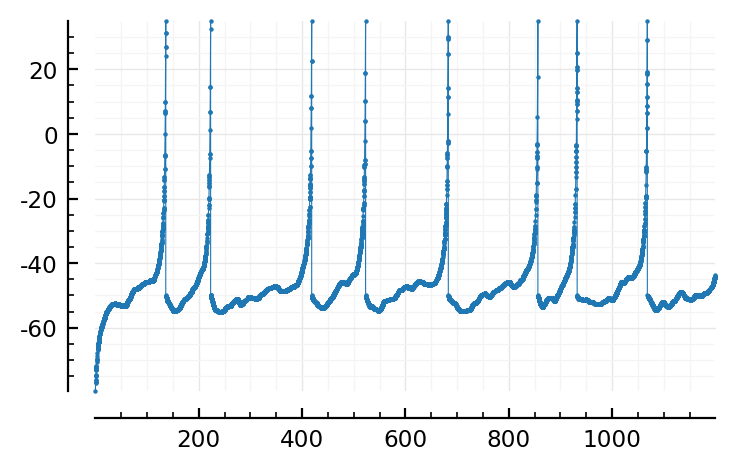

In [56]:
plot(sol);